In [ ]:
# STEP 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd
import os
import re

In [ ]:


# Adjust these paths based on your Drive structure
CSV_PATH = "/content/Annotated_data-Final_data.csv"
IMG_FOLDER_PATH = "/content/drive/MyDrive/LGBTQ Memes/unique_images"
SAVE_PATH = "/content/drive/MyDrive/LGBTQ Memesprocessed_data.csv"

# Load CSV
df = pd.read_csv(CSV_PATH)




In [ ]:
df.head()

,Index,Filename,Extracted Text,Annotator_1,Annotator_2
0,1,add_1.webp,online real life #sees Tm so gay an't think st...,0,0
1,5,add_5.jpg,Breaking911 @Breaking911 4h BREAKING: First op...,1,1
2,8,add_8.jpeg,2.30 google com/search?q= Google @Fabrtzhfo Ri...,-1,-1
3,12,add_12.jpeg,Empieza Junio: Ay; Dios Que calor hace aqui Me...,-1,-1
4,13,add_13.jpg,NaN,-1,-1


In [ ]:
df.columns = df.columns.str.strip()



In [ ]:
df = df[(df['Annotator_1'] != -1) & (df['Annotator_2'] != -1)]
df = df[df['Annotator_1'] == df['Annotator_2']]


In [ ]:
# Drop rows with missing OCR text
df = df.dropna(subset=['Extracted Text'])

# Add final 'label' column
df['label'] = df['Annotator_1'].astype(int)

# Show results
print(df.head())
print(f"[INFO] Cleaned dataset size: {len(df)} rows")

   Index    Filename                                     Extracted Text  \
0      1  add_1.webp  online real life #sees Tm so gay an't think st...   
1      5   add_5.jpg  Breaking911 @Breaking911 4h BREAKING: First op...   
6     15  add_15.png  don't have a what's gender your gender? meant ...   
8     18  add_18.jpg          LET'S GET ONE THING STRAIGHT PMNOT LGBTIQ   
9     19  add_19.jpg  KNOW THE DIFFERENCEI Trans woman Femboy Drag Q...   

   Annotator_1  Annotator_2  label  
0            0            0      0  
1            1            1      1  
6            0            0      0  
8            0            0      0  
9            0            0      0  
[INFO] Cleaned dataset size: 1320 rows


<ipython-input-16-f050b831518c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['Annotator_1'].astype(int)


In [ ]:
!pip install textblob


In [ ]:
from textblob import TextBlob

# Function to correct spelling mistakes
def correct_spelling(text):
    if pd.isnull(text):
        return ""
    return str(TextBlob(text).correct())

# Apply to the 'Extracted Text' column
df['corrected_text'] = df['Extracted Text'].apply(correct_spelling)

# Check the result
print(df[['Extracted Text', 'corrected_text']].head())

# we also have autocorrect and pyspellchecker


KeyboardInterrupt: 

In [ ]:
!pip install pyspellchecker


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 98.4 MB/s eta 0:00:00


In [ ]:
from spellchecker import SpellChecker

# Initialize the spell checker
spell = SpellChecker()

# Function to correct spelling mistakes and handle None or empty strings
def correct_spelling_pyspellchecker(text):
    if not text:
        return ""  # Return an empty string if the text is None or empty
    words = text.split()
    corrected_words = [spell.correction(word) for word in words]
    # Ensure no None values are returned in the list before joining
    corrected_words = [word if word is not None else "" for word in corrected_words]
    return " ".join(corrected_words)

# Drop rows where 'Extracted Text' is NaN
df = df.dropna(subset=['Extracted Text'])

# Apply to the 'Extracted Text' column
df['corrected_text'] = df['Extracted Text'].apply(correct_spelling_pyspellchecker)

# Check the result
print(df[['Extracted Text', 'corrected_text']].head())


KeyboardInterrupt: 

In [ ]:
!pip install symspellpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.1/144.1 kB 14.0 MB/s eta 0:00:00


In [ ]:
!wget https://raw.githubusercontent.com/mammothb/symspellpy/master/symspellpy/frequency_dictionary_en_82_765.txt


--2025-05-08 09:48:33--  https://raw.githubusercontent.com/mammothb/symspellpy/master/symspellpy/frequency_dictionary_en_82_765.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1332879 (1.3M) [text/plain]
Saving to: ‘frequency_dictionary_en_82_765.txt’

frequency_dictionar 100%[===================>]   1.27M  --.-KB/s    in 0.02s   

2025-05-08 09:48:33 (83.2 MB/s) - ‘frequency_dictionary_en_82_765.txt’ saved [1332879/1332879]



In [ ]:
sym_spell.load_dictionary("/content/frequency_dictionary_en_82_765.txt", term_index=0, count_index=1)


True

In [ ]:
from symspellpy import SymSpell, Verbosity
import pandas as pd
import re
from tqdm import tqdm

# Initialize SymSpell
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

cache = {}
def correct_spelling_symspell(text):
    if not isinstance(text, str) or not text.strip():
        return ""
    text = re.sub(r'[^\w\s]', '', text)
    corrected_words = []
    for word in text.split():
        if word in cache:
            corrected = cache[word]
        else:
            suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
            corrected = suggestions[0].term if suggestions else word
            cache[word] = corrected
        corrected_words.append(corrected)
    return " ".join(corrected_words)

# Example: Drop NaNs and apply with progress bar
df = df.dropna(subset=['Extracted Text'])
tqdm.pandas()
df['corrected_text'] = df['Extracted Text'].progress_apply(correct_spelling_symspell)

# Preview result
print(df[['Extracted Text', 'corrected_text']].head())


100%|██████████| 1320/1320 [00:00<00:00, 31493.78it/s]

                                      Extracted Text  \
0  online real life #sees Tm so gay an't think st...   
1  Breaking911 @Breaking911 4h BREAKING: First op...   
6  don't have a what's gender your gender? meant ...   
8          LET'S GET ONE THING STRAIGHT PMNOT LGBTIQ   
9  KNOW THE DIFFERENCEI Trans woman Femboy Drag Q...   

                                      corrected_text  
0  online real life sees Tm so gay ant think stra...  
1  Breaking911 Breaking911 4h BREAKING First open...  
6  dont have a whats gender your gender meant sex...  
8           LETS GET ONE THING STRAIGHT PMNOT LGBTIQ  
9  KNOW THE DIFFERENCEI Trans woman Femboy Drag Q...  


In [ ]:
df.shape

(1320, 8)

In [ ]:
!pip install Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 60.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import Levenshtein

# Function to calculate Levenshtein Distance
def calculate_levenshtein(text1, text2):
    return Levenshtein.distance(text1, text2)

from tqdm import tqdm
tqdm.pandas()

mask = df['Extracted Text'] != df['corrected_text']
df.loc[mask, 'levenshtein_distance'] = df[mask].progress_apply(
    lambda row: Levenshtein.distance(row['Extracted Text'], row['corrected_text']), axis=1)
df['levenshtein_distance'] = df['levenshtein_distance'].fillna(0).astype(int)

# Print the results
print(df[['Extracted Text', 'corrected_text', 'levenshtein_distance']].head())


100%|██████████| 1205/1205 [00:00<00:00, 36833.16it/s]

                                      Extracted Text  \
0  online real life #sees Tm so gay an't think st...   
1  Breaking911 @Breaking911 4h BREAKING: First op...   
6  don't have a what's gender your gender? meant ...   
8          LET'S GET ONE THING STRAIGHT PMNOT LGBTIQ   
9  KNOW THE DIFFERENCEI Trans woman Femboy Drag Q...   

                                      corrected_text  levenshtein_distance  
0  online real life sees Tm so gay ant think stra...                     5  
1  Breaking911 Breaking911 4h BREAKING First open...                    10  
6  dont have a whats gender your gender meant sex...                     4  
8           LETS GET ONE THING STRAIGHT PMNOT LGBTIQ                     1  
9  KNOW THE DIFFERENCEI Trans woman Femboy Drag Q...                    21  


In [ ]:
average_levenshtein = df['levenshtein_distance'].mean()
print(f"Average Levenshtein Distance: {average_levenshtein:.2f}")


Average Levenshtein Distance: 8.47


In [ ]:
# Calculate normalized Levenshtein distance
df['normalized_levenshtein'] = df.apply(
    lambda row: row['levenshtein_distance'] / max(len(row['Extracted Text']), len(row['corrected_text']))
    if max(len(row['Extracted Text']), len(row['corrected_text'])) > 0 else 0,
    axis=1
)

# Compute average normalized distance
average_normalized = df['normalized_levenshtein'].mean()
print(f"Average Normalized Levenshtein Distance: {average_normalized:.4f}")


Average Normalized Levenshtein Distance: 0.0361


In [ ]:
df.shape

(1320, 9)

In [ ]:
# Full image path
df['image_path'] = df['Filename'].apply(lambda x: os.path.join(IMG_FOLDER_PATH, x))


In [ ]:
# Clean OCR text
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    return text.strip()

df['clean_text'] = df['Extracted Text'].apply(clean_text)


In [ ]:
# Drop rows with missing or unresolved fields
df.dropna(subset=['label', 'clean_text'], inplace=True)


In [ ]:
# Optional: Check if image files actually exist
df = df[df['image_path'].apply(os.path.exists)]


In [ ]:
# Convert label to integer
df['label'] = df['label'].astype(int)


In [ ]:
# Save processed CSV
df.to_csv('/content/Memesprocessed_data.csv', index=False)
print(f"[INFO] Preprocessed data saved at: {'/content/Memesprocessed_data.csv'}")


[INFO] Preprocessed data saved at: /content/Memesprocessed_data.csv


In [ ]:
import pandas as pd
df = pd.read_csv('/content/Memesprocessed_data.csv')

In [ ]:
df.head()

,Index,Filename,Extracted Text,Annotator_1,Annotator_2,label,corrected_text,levenshtein_distance,normalized_levenshtein,image_path,clean_text
0,1,add_1.webp,online real life #sees Tm so gay an't think st...,0,0,0,online real life sees Tm so gay ant think stra...,5,0.058140,/content/drive/MyDrive/LGBTQ Memes/unique_imag...,online real life #sees Tm so gay an't think st...
1,5,add_5.jpg,Breaking911 @Breaking911 4h BREAKING: First op...,1,1,1,Breaking911 Breaking911 4h BREAKING First open...,10,0.040000,/content/drive/MyDrive/LGBTQ Memes/unique_imag...,Breaking911 @Breaking911 4h BREAKING: First op...
2,15,add_15.png,don't have a what's gender your gender? meant ...,0,0,0,dont have a whats gender your gender meant sex...,4,0.048780,/content/drive/MyDrive/LGBTQ Memes/unique_imag...,don't have a what's gender your gender? meant ...
3,18,add_18.jpg,LET'S GET ONE THING STRAIGHT PMNOT LGBTIQ,0,0,0,LETS GET ONE THING STRAIGHT PMNOT LGBTIQ,1,0.024390,/content/drive/MyDrive/LGBTQ Memes/unique_imag...,LET'S GET ONE THING STRAIGHT PMNOT LGBTIQ
4,19,add_19.jpg,KNOW THE DIFFERENCEI Trans woman Femboy Drag Q...,0,0,0,KNOW THE DIFFERENCEI Trans woman Femboy Drag Q...,21,0.021042,/content/drive/MyDrive/LGBTQ Memes/unique_imag...,KNOW THE DIFFERENCEI Trans woman Femboy Drag Q...


In [ ]:
# Check the distribution of the 'label' column
label_counts = df['label'].value_counts()

# Calculate the percentage distribution of each label
label_percentage = df['label'].value_counts(normalize=True) * 100

print("Label Counts:")
print(label_counts)

print("\nLabel Percentage Distribution:")
print(label_percentage)


Label Counts:
label
1    1068
0     252
Name: count, dtype: int64

Label Percentage Distribution:
label
1    80.909091
0    19.090909
Name: proportion, dtype: float64


In [ ]:
pip install transformers clip-by-openai


  Using cached clip_by_openai-1.1-py3-none-any.whl.metadata (369 bytes)
INFO: pip is looking at multiple versions of clip-by-openai to determine which version is compatible with other requirements. This could take a while.
  Using cached clip_by_openai-1.0.1-py3-none-any.whl.metadata (407 bytes)
  Using cached clip_by_openai-0.1.1.5-py3-none-any.whl.metadata (8.6 kB)
  Using cached clip_by_openai-0.1.1.4-py3-none-any.whl.metadata (8.6 kB)
  Using cached clip_by_openai-0.1.1.3-py3-none-any.whl.metadata (8.7 kB)
  Using cached clip_by_openai-0.1.1.2-py3-none-any.whl.metadata (9.0 kB)
  Using cached clip_by_openai-0.1.1-py3-none-any.whl.metadata (9.0 kB)
  Using cached clip_by_openai-0.1.0-py3-none-any.whl.metadata (9.0 kB)
INFO: pip is still looking at multiple versions of clip-by-openai to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install clip-by-openai==0.1.0, clip-by-openai==0.1.1, clip-by-openai==0.1.1.2, clip-by-openai==0.1

In [ ]:
pip install torch==2.7.0 torchvision==0.22.0


In [ ]:
df.shape

(1320, 11)

In [ ]:
!pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-jqp2xb22
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-jqp2xb22
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [ ]:
# STEP 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
IMG_FOLDER_PATH = "/content/drive/MyDrive/LGBTQ Memes/unique_images"

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import torch
import clip
from PIL import Image
import pandas as pd
from tqdm import tqdm

# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device)

def get_text_embedding(text):
    # Split text into chunks of 77 tokens or less
    max_tokens = 77
    chunks = [text[i:i+max_tokens] for i in range(0, len(text), max_tokens)]

    # Encode each chunk separately and average the embeddings
    embeddings = []
    for chunk in chunks:
        text_input = clip.tokenize([chunk]).to(device)
        with torch.no_grad():
            chunk_features = model.encode_text(text_input)
        chunk_features /= chunk_features.norm(dim=-1, keepdim=True)  # Normalize
        embeddings.append(chunk_features.cpu().numpy())

    # Average the embeddings of all chunks
    embeddings = np.mean(embeddings, axis=0)
    return embeddings

# Function to process and compute embeddings for images
def get_image_embedding(image_path):
    # Open and preprocess the image
    image = Image.open(image_path)
    image_input = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image_input)
    image_features /= image_features.norm(dim=-1, keepdim=True)  # Normalize
    return image_features.cpu().numpy()

# Apply embeddings extraction for each row
def generate_embeddings(df):
    text_embeddings = []
    image_embeddings = []

    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        text_embedding = get_text_embedding(row['clean_text'])
        image_embedding = get_image_embedding(row['image_path'])

        text_embeddings.append(text_embedding)
        image_embeddings.append(image_embedding)

    # Add embeddings to the DataFrame
    df['text_embedding'] = text_embeddings
    df['image_embedding'] = image_embeddings
    return df

# # Assuming 'df' is your dataframe loaded from the CSV
# df = generate_embeddings(df)

# # Save the dataframe with embeddings
# df.to_csv('/path_to_save/processed_with_embeddings.csv', index=False)
# print(f"[INFO] Preprocessed data with embeddings saved at: /path_to_save/processed_with_embeddings.csv")


100%|███████████████████████████████████████| 338M/338M [00:03<00:00, 90.8MiB/s]


In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into train, validation, and test sets (e.g., 70% train, 15% validation, 15% test)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Now, generate embeddings for each of the splits
train_df = generate_embeddings(train_df)
valid_df = generate_embeddings(valid_df)
test_df = generate_embeddings(test_df)

# Optionally, save each dataframe with embeddings
train_df.to_csv('train_with_embeddings.csv', index=False)
valid_df.to_csv('valid_with_embeddings.csv', index=False)
test_df.to_csv('test_with_embeddings.csv', index=False)


100%|██████████| 198/198 [01:42<00:00,  1.93it/s]


In [ ]:
import torch
import clip
from PIL import Image
import pandas as pd
from tqdm import tqdm

# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-L/14@336px", device)

def get_text_embedding(text):
    # Split text into chunks of 77 tokens or less
    max_tokens = 77
    chunks = [text[i:i+max_tokens] for i in range(0, len(text), max_tokens)]

    # Encode each chunk separately and average the embeddings
    embeddings = []
    for chunk in chunks:
        text_input = clip.tokenize([chunk]).to(device)
        with torch.no_grad():
            chunk_features = model.encode_text(text_input)
        chunk_features /= chunk_features.norm(dim=-1, keepdim=True)  # Normalize
        embeddings.append(chunk_features.cpu().numpy())

    # Average the embeddings of all chunks
    embeddings = np.mean(embeddings, axis=0)
    return embeddings

# Function to process and compute embeddings for images
def get_image_embedding(image_path):
    # Open and preprocess the image
    image = Image.open(image_path)
    image_input = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image_input)
    image_features /= image_features.norm(dim=-1, keepdim=True)  # Normalize
    return image_features.cpu().numpy()

# Apply embeddings extraction for each row
def generate_embeddings(df):
    text_embeddings = []
    image_embeddings = []

    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        text_embedding = get_text_embedding(row['clean_text'])
        image_embedding = get_image_embedding(row['image_path'])

        text_embeddings.append(text_embedding)
        image_embeddings.append(image_embedding)

    # Add embeddings to the DataFrame
    df['text_embedding'] = text_embeddings
    df['image_embedding'] = image_embeddings
    return df

# # Assuming 'df' is your dataframe loaded from the CSV
# df = generate_embeddings(df)

# # Save the dataframe with embeddings
# df.to_csv('/path_to_save/processed_with_embeddings.csv', index=False)
# print(f"[INFO] Preprocessed data with embeddings saved at: /path_to_save/processed_with_embeddings.csv")


In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into train, validation, and test sets (e.g., 70% train, 15% validation, 15% test)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Now, generate embeddings for each of the splits
train_df = generate_embeddings(train_df)
valid_df = generate_embeddings(valid_df)
test_df = generate_embeddings(test_df)

# Optionally, save each dataframe with embeddings
train_df.to_csv('train_with_embeddings_ViT-L14_336px.csv', index=False)
valid_df.to_csv('valid_with_embeddings_ViT-L14_336px.csv', index=False)
test_df.to_csv('test_with_embeddings_ViT-L14_336px.csv', index=False)


100%|██████████| 198/198 [00:18<00:00, 10.68it/s]


In [ ]:
import torch
import clip
from PIL import Image
import pandas as pd
from tqdm import tqdm

# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("RN50x64", device)

# Function to process and compute embeddings for text
# def get_text_embedding(text):
#     # Encode the text using CLIP
#     text_input = clip.tokenize([text]).to(device)
#     with torch.no_grad():
#         text_features = model.encode_text(text_input)
#     text_features /= text_features.norm(dim=-1, keepdim=True)  # Normalize
#     return text_features.cpu().numpy()
def get_text_embedding(text):
    # Split text into chunks of 77 tokens or less
    max_tokens = 77
    chunks = [text[i:i+max_tokens] for i in range(0, len(text), max_tokens)]

    # Encode each chunk separately and average the embeddings
    embeddings = []
    for chunk in chunks:
        text_input = clip.tokenize([chunk]).to(device)
        with torch.no_grad():
            chunk_features = model.encode_text(text_input)
        chunk_features /= chunk_features.norm(dim=-1, keepdim=True)  # Normalize
        embeddings.append(chunk_features.cpu().numpy())

    # Average the embeddings of all chunks
    embeddings = np.mean(embeddings, axis=0)
    return embeddings

# Function to process and compute embeddings for images
def get_image_embedding(image_path):
    # Open and preprocess the image
    image = Image.open(image_path)
    image_input = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image_input)
    image_features /= image_features.norm(dim=-1, keepdim=True)  # Normalize
    return image_features.cpu().numpy()

# Apply embeddings extraction for each row
def generate_embeddings(df):
    text_embeddings = []
    image_embeddings = []

    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        text_embedding = get_text_embedding(row['clean_text'])
        image_embedding = get_image_embedding(row['image_path'])

        text_embeddings.append(text_embedding)
        image_embeddings.append(image_embedding)

    # Add embeddings to the DataFrame
    df['text_embedding'] = text_embeddings
    df['image_embedding'] = image_embeddings
    return df

# # Assuming 'df' is your dataframe loaded from the CSV
# df = generate_embeddings(df)

# # Save the dataframe with embeddings
# df.to_csv('/path_to_save/processed_with_embeddings.csv', index=False)
# print(f"[INFO] Preprocessed data with embeddings saved at: /path_to_save/processed_with_embeddings.csv")


100%|█████████████████████████████████████| 1.26G/1.26G [01:40<00:00, 13.5MiB/s]


In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into train, validation, and test sets (e.g., 70% train, 15% validation, 15% test)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Now, generate embeddings for each of the splits
train_df = generate_embeddings(train_df)
valid_df = generate_embeddings(valid_df)
test_df = generate_embeddings(test_df)

# Optionally, save each dataframe with embeddings
train_df.to_csv('train_with_embeddings_RN50x64.csv', index=False)
valid_df.to_csv('valid_with_embeddings_RN50x64.csv', index=False)
test_df.to_csv('test_with_embeddings_RN50x64.csv', index=False)


100%|██████████| 198/198 [00:24<00:00,  8.00it/s]


In [ ]:
import ast
import numpy as np


In [ ]:
import re
import ast
import numpy as np
import pandas as pd

def clean_embedding_string(embedding_str):
    # Fix spacing issues: insert comma between floats if missing
    fixed_str = re.sub(r'(?<=\d)\s+(?=[+-]?\d)', ', ', embedding_str)

    try:
        return np.array(ast.literal_eval(fixed_str))
    except Exception as e:
        print(f"Error parsing:\n{embedding_str[:80]}...\n{e}")
        return None


#Training for ViT-B32

In [ ]:
import pandas as pd

# Load the CSV file
file_path = '/content/test_with_embeddings_ViT-B32.csv'
df = pd.read_csv(file_path)

# Show the first few rows of the dataset
print("First 5 rows of the dataset:")
print(df.head())

# Check the basic information (e.g., data types, non-null counts)
print("\nBasic information about the dataset:")
df_info = df.info()

# Display summary statistics of numerical columns
print("\nSummary statistics of numerical columns:")
df_summary = df.describe()

# Check for missing values
print("\nMissing values in the dataset:")
missing_values = df.isnull().sum()

# Check for class distribution in the label column
print("\nClass distribution in the 'label' column:")
class_distribution = df['label'].value_counts()

# Check for unique values in each column (to inspect categorical columns)
print("\nUnique values in each column:")
unique_values = df.nunique()

# Check the distribution of text embeddings and image embeddings (if needed)
# You can inspect the length of the embeddings if they are in text form
print("\nLength of text embeddings in the dataset:")
df['text_embedding_length'] = df['text_embedding'].apply(lambda x: len(eval(x)))  # Assuming embeddings are stored as strings of lists
text_embedding_lengths = df['text_embedding_length'].describe()

print("\nText embedding length summary:")
print(text_embedding_lengths)

# Check for image embeddings (if available)
print("\nLength of image embeddings in the dataset:")
df['image_embedding_length'] = df['image_embedding'].apply(lambda x: len(eval(x)))  # Assuming embeddings are stored as strings of lists
image_embedding_lengths = df['image_embedding_length'].describe()

print("\nImage embedding length summary:")
print(image_embedding_lengths)


First 5 rows of the dataset:
   Index      Filename                                     Extracted Text  \
0    999   img_427.png  Laura Kenneally @laurakenneally9 Jun 14,2013 S...   
1   1945  img_1373.png  PROTECTING MY CHILDREN FROM YOUR IDEOLOGY IS N...   
2   1463   img_891.png  JTtheSuperGamer @JTtheSG Jun 15,2024 Another w...   
3    548   add_548.jpg  THE CHURCH IS NOT CHURCH WIthOUT OUR LGBTQIA+ ...   
4    355   add_355.jpg  roses are red, grass is green NEVER UNDERESTMM...   

   Annotator_1  Annotator_2  label  \
0            1            1      1   
1            1            1      1   
2            1            1      1   
3            0            0      0   
4            0            0      0   

                                      corrected_text  levenshtein_distance  \
0  Laura Kenneally laurakenneally9 Jun 142013 Sti...                     4   
1  PROTECTING MY CHILDREN FROM YOUR IDEOLOGY IS N...                     0   
2  JTtheSuperGamer JTtheSG Jun 152024 Another

SyntaxError: invalid syntax. Perhaps you forgot a comma? (<string>, line 1)

In [ ]:
df = pd.read_csv('/content/train_with_embeddings_ViT-B32.csv')

# Apply to both embedding columns
df['text_embedding_fixed'] = df['text_embedding'].apply(clean_embedding_string)
df['image_embedding_fixed'] = df['image_embedding'].apply(clean_embedding_string)

# Drop rows where parsing failed
df = df.dropna(subset=['text_embedding_fixed', 'image_embedding_fixed'])

# Stack into numpy arrays
X_text = np.stack(df['text_embedding_fixed'].values)
X_image = np.stack(df['image_embedding_fixed'].values)

# Target labels
y = df['label'].values


In [ ]:
df.head()

,Index,Filename,Extracted Text,Annotator_1,Annotator_2,label,corrected_text,levenshtein_distance,normalized_levenshtein,image_path,clean_text,text_embedding,image_embedding
0,999,img_427.png,"Laura Kenneally @laurakenneally9 Jun 14,2013 S...",1,1,1,Laura Kenneally laurakenneally9 Jun 142013 Sti...,4,0.029197,/content/drive/MyDrive/LGBTQ Memes/unique_imag...,"Laura Kenneally @laurakenneally9 Jun 14,2013 S...",[[ 7.3242e-03 4.1103e-04 -6.7444e-03 1.3069e...,[[-2.8473e-02 7.0190e-03 -1.2848e-02 1.3016e...
1,1945,img_1373.png,PROTECTING MY CHILDREN FROM YOUR IDEOLOGY IS N...,1,1,1,PROTECTING MY CHILDREN FROM YOUR IDEOLOGY IS N...,0,0.000000,/content/drive/MyDrive/LGBTQ Memes/unique_imag...,PROTECTING MY CHILDREN FROM YOUR IDEOLOGY IS N...,[[ 2.1378e-02 1.5717e-02 5.6305e-03 -1.2344e...,[[ 8.8577e-03 -1.6098e-02 3.8452e-02 -3.9458e...
2,1463,img_891.png,"JTtheSuperGamer @JTtheSG Jun 15,2024 Another w...",1,1,1,JTtheSuperGamer JTtheSG Jun 152024 Another way...,9,0.031250,/content/drive/MyDrive/LGBTQ Memes/unique_imag...,"JTtheSuperGamer @JTtheSG Jun 15,2024 Another w...",[[ 1.1826e-02 -2.6489e-02 7.7362e-03 1.4992e...,[[-1.8433e-02 -2.0248e-02 -2.1866e-02 1.1892e...
3,548,add_548.jpg,THE CHURCH IS NOT CHURCH WIthOUT OUR LGBTQIA+ ...,0,0,0,THE CHURCH IS NOT CHURCH WIthOUT OUR LGBTQIA M...,1,0.018868,/content/drive/MyDrive/LGBTQ Memes/unique_imag...,THE CHURCH IS NOT CHURCH WIthOUT OUR LGBTQIA+ ...,[[ 2.5299e-02 1.1147e-02 -2.0027e-03 -8.3566e...,[[ 3.8910e-02 -2.1393e-02 2.2858e-02 1.3893e...
4,355,add_355.jpg,"roses are red, grass is green NEVER UNDERESTMM...",0,0,0,roses are red grass is green NEVER UNDERESTMMA...,2,0.022222,/content/drive/MyDrive/LGBTQ Memes/unique_imag...,"roses are red, grass is green NEVER UNDERESTMM...",[[-7.3433e-03 1.8433e-02 6.6910e-03 1.1795e...,[[ 7.2136e-03 4.0710e-02 2.9816e-02 -1.7138e...


In [ ]:
df.shape

(924, 15)

In [ ]:
X_text_flat = X_text.reshape(X_text.shape[0], -1)
X_image_flat = X_image.reshape(X_image.shape[0], -1)

# Then concatenate or use individually
X = np.concatenate([X_text_flat, X_image_flat], axis=1)  # Option C


Epoch 1/30 - Train Loss: 0.3966, Train Acc: 0.8011, Val Loss: 0.2752, Val Acc: 0.8703
Epoch 2/30 - Train Loss: 0.1749, Train Acc: 0.9364, Val Loss: 0.2717, Val Acc: 0.8919
Epoch 3/30 - Train Loss: 0.0803, Train Acc: 0.9783, Val Loss: 0.3075, Val Acc: 0.8865
Epoch 4/30 - Train Loss: 0.0254, Train Acc: 0.9973, Val Loss: 0.3706, Val Acc: 0.8865
Epoch 5/30 - Train Loss: 0.0103, Train Acc: 0.9986, Val Loss: 0.4151, Val Acc: 0.8973
Early stopping triggered at epoch 5

Final Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.76      0.77        45
           1       0.92      0.94      0.93       140

    accuracy                           0.89       185
   macro avg       0.86      0.85      0.85       185
weighted avg       0.89      0.89      0.89       185



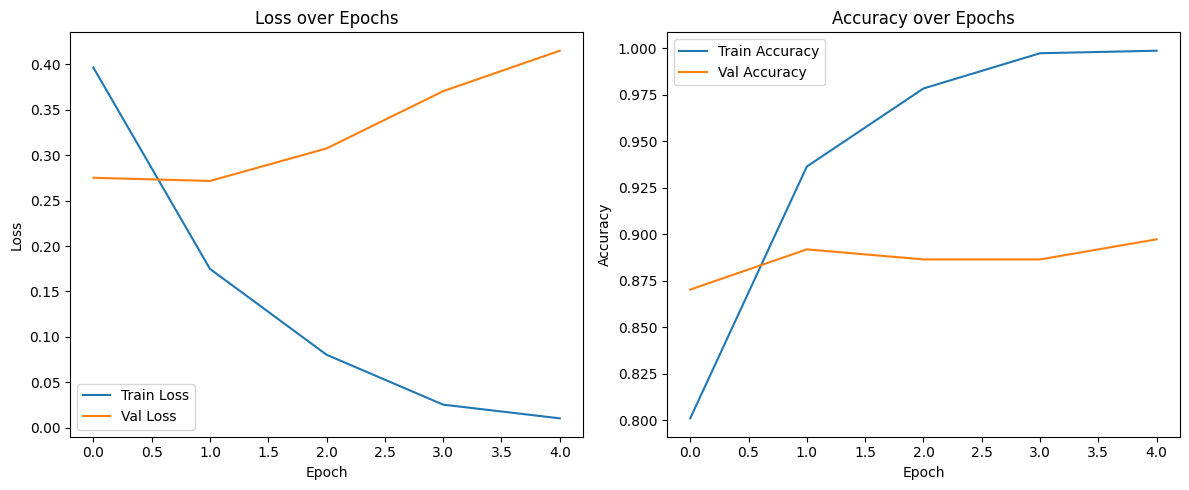

In [ ]:
# Training Code 1 with graphs and callback + reg


import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import copy

# Preprocess and split
X_text_flat = X_text.reshape(X_text.shape[0], -1)
X_image_flat = X_image.reshape(X_image.shape[0], -1)
X = np.concatenate([X_text_flat, X_image_flat], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Loaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=32)

# MLP model
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.4),  # Increased dropout for regularization
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        return self.net(x)

# Initialize
input_dim = X.shape[1]
model_2 = MLP(input_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=1e-3, weight_decay=1e-4)  # L2 regularization

# Metric tracking
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Early stopping and checkpoint
best_val_loss = np.inf
best_model_wts = copy.deepcopy(model_2.state_dict())
patience = 3
wait = 0

# Training
epochs = 30
for epoch in range(epochs):
    model_2.train()
    train_loss = 0.0
    correct_train = 0

    for xb, yb in train_loader:
        preds = model_2(xb)
        loss = criterion(preds, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * xb.size(0)
        correct_train += (preds.argmax(1) == yb).sum().item()

    train_loss /= len(train_loader.dataset)
    train_acc = correct_train / len(train_loader.dataset)

    # Validation
    model_2.eval()
    val_loss = 0.0
    correct_val = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model_2(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * xb.size(0)
            correct_val += (preds.argmax(1) == yb).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = correct_val / len(val_loader.dataset)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping & checkpointing
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model_2.state_dict())
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# Load best weights
model_2.load_state_dict(best_model_wts)

# Final evaluation
model_2.eval()
with torch.no_grad():
    y_pred = model_2(X_val_tensor).argmax(dim=1).numpy()
    print("\nFinal Classification Report:\n", classification_report(y_val, y_pred))

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 24.1 MB/s eta 0:00:00


In [ ]:
# HYperparameter Tuning for Embeddings_1


import torch
import torch.nn as nn
import torch.nn.functional as F
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# ---- Dataset Setup (Assumes You Already Have These) ----
X_text_flat = X_text.reshape(X_text.shape[0], -1)
X_image_flat = X_image.reshape(X_image.shape[0], -1)
X = np.concatenate([X_text_flat, X_image_flat], axis=1)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)

# ---- Losses ----
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

# ---- Dynamic MLP ----
class DynamicMLP(nn.Module):
    def __init__(self, input_dim, hidden_layers, activation, dropout_rate):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(activation())
            layers.append(nn.Dropout(dropout_rate))
            prev = h
        layers.append(nn.Linear(prev, 2))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# ---- Optuna Objective ----
def objective(trial):
    # Hyperparameters
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "AdamW", "SGD"])
    lr = trial.suggest_categorical("lr", [1e-2, 1e-3, 5e-4])
    weight_decay = trial.suggest_categorical("weight_decay", [1e-3, 1e-4, 0])
    dropout = trial.suggest_categorical("dropout", [0.2, 0.3, 0.4])
    activation_name = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU", "GELU"])
    loss_fn_name = trial.suggest_categorical("loss_fn", ["FocalLoss", "CrossEntropy"])
    layer_choice = trial.suggest_categorical("layer_config", [
        [256, 128],
        [512, 256, 128],
        [512, 256, 128, 64]
    ])

    # Activation
    activation = {"ReLU": nn.ReLU, "LeakyReLU": nn.LeakyReLU, "GELU": nn.GELU}[activation_name]

    # Model
    input_dim = X_train_tensor.shape[1]
    model = DynamicMLP(input_dim, layer_choice, activation, dropout)

    # Optimizer
    if optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    else:
        optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Loss function
    if loss_fn_name == "FocalLoss":
        criterion = FocalLoss()
    else:
        class_counts = np.bincount(y_train)
        weights = torch.tensor(1. / class_counts, dtype=torch.float32)
        criterion = nn.CrossEntropyLoss(weight=weights)

    # Training loop (fewer epochs for speed)
    model.train()
    for epoch in range(15):
        for xb, yb in train_loader:
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        preds = model(X_val_tensor)
        acc = accuracy_score(y_val, preds.argmax(dim=1).numpy())
    return acc

# ---- Run Study ----
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, timeout=1800)

# ---- Best Results ----
print("Best Trial:")
trial = study.best_trial
print(f"  Accuracy: {trial.value}")
print("  Best Params:", trial.params)


[I 2025-05-11 14:24:30,299] A new study created in memory with name: no-name-f170a094-630d-4b4b-bae5-439681245ae4
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 128] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [512, 256, 128] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [512, 256, 128, 64] which is of type list.
  warnings.warn(message)
[I 2025-05-11 14:24:34,996] Trial 0 finished with value: 0.837837837

Best Trial:
  Accuracy: 0.8972972972972973
  Best Params: {'optimizer': 'Adam', 'lr': 0.0005, 'weight_decay': 0.001, 'dropout': 0.2, 'activation': 'ReLU', 'loss_fn': 'CrossEntropy', 'layer_config': [512, 256, 128, 64]}


✅ Epoch 1: New best model saved with Val Acc: 0.8108
✅ Epoch 3: New best model saved with Val Acc: 0.8703
✅ Epoch 9: New best model saved with Val Acc: 0.8811
Epoch 10/50 | Train Loss: 1.7164 | Train Acc: 0.9946 | Val Loss: 2.3419 | Val Acc: 0.8757
✅ Epoch 12: New best model saved with Val Acc: 0.8919
Epoch 20/50 | Train Loss: 0.9263 | Train Acc: 0.9959 | Val Loss: 2.9900 | Val Acc: 0.8541
Epoch 30/50 | Train Loss: 0.3694 | Train Acc: 1.0000 | Val Loss: 3.6859 | Val Acc: 0.8757
Epoch 40/50 | Train Loss: 0.5190 | Train Acc: 0.9959 | Val Loss: 4.6668 | Val Acc: 0.8703
Epoch 50/50 | Train Loss: 0.7948 | Train Acc: 0.9905 | Val Loss: 4.3337 | Val Acc: 0.8811

📊 Evaluation Metrics:
Accuracy : 0.8919
Precision: 0.9167
Recall   : 0.9429
F1 Score : 0.9296
AUC      : 0.9202


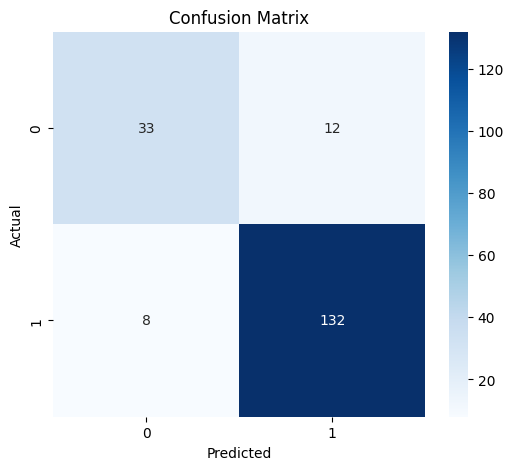

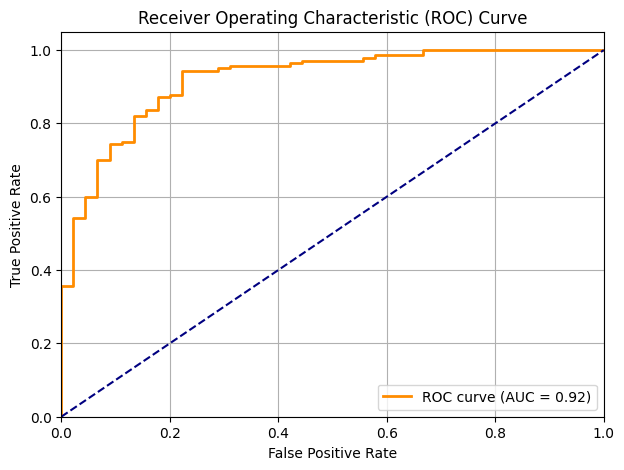

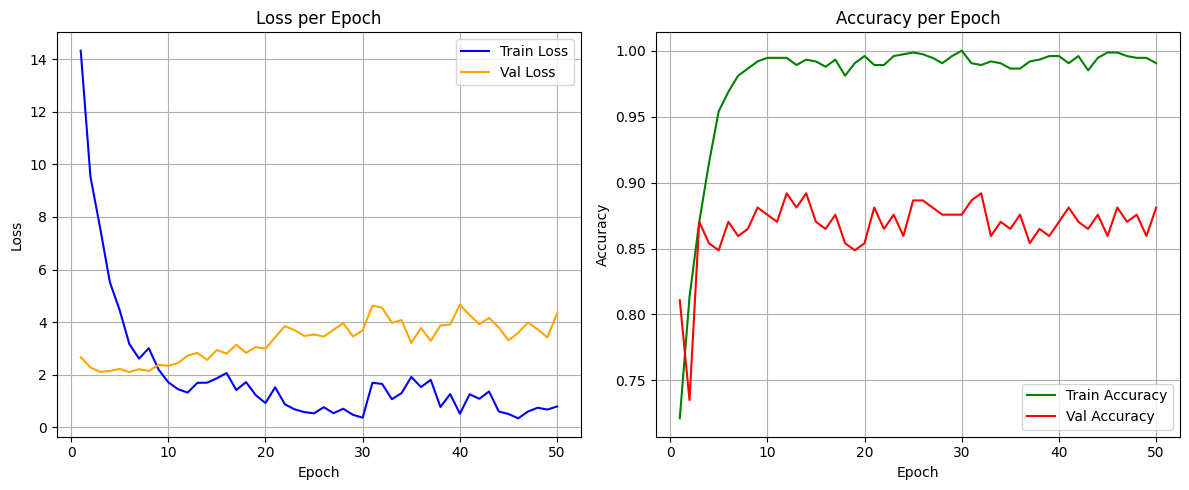

In [ ]:
#Best Model Code

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, roc_curve, auc, f1_score,
                             accuracy_score, precision_score, recall_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# --- Dataset setup (use your original X_text, X_image, y) ---
X_text_flat = X_text.reshape(X_text.shape[0], -1)
X_image_flat = X_image.reshape(X_image.shape[0], -1)
X = np.concatenate([X_text_flat, X_image_flat], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)

# --- Model Definition ---
class DynamicMLP(nn.Module):
    def __init__(self, input_dim, hidden_layers, dropout_rate):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev = h
        layers.append(nn.Linear(prev, 2))  # Binary classification
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# --- Model Setup with Best Trial ---
input_dim = X_train_tensor.shape[1]
best_layers = [512, 256, 128, 64]
model = DynamicMLP(input_dim, best_layers, dropout_rate=0.2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.001)

# Use weighted CrossEntropy
class_counts = np.bincount(y_train)
weights = torch.tensor(1. / class_counts, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=weights)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=32)

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

best_val_acc = 0.0
best_model_path = "/content/best_model_ViTB32.pth"


# -- Training ---

n_epochs = 50  # Ensure this is defined

for epoch in range(n_epochs):
    model.train()
    epoch_loss, correct, total = 0, 0, 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        preds_train = out.argmax(dim=1)
        correct += (preds_train == yb).sum().item()
        total += yb.size(0)

    train_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(train_acc)

    # --- Validation ---
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            out = model(xb)
            loss = criterion(out, yb)
            val_loss += loss.item()
            preds_val = out.argmax(dim=1)
            val_correct += (preds_val == yb).sum().item()
            val_total += yb.size(0)

    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # --- Callback: Save best model ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Epoch {epoch+1}: New best model saved with Val Acc: {val_acc:.4f}")

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {epoch_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")



# --- Evaluation ---

model.load_state_dict(torch.load(best_model_path))
model.eval()


model.eval()
with torch.no_grad():
    logits = model(X_val_tensor)
    probs = torch.softmax(logits, dim=1)[:, 1].numpy()  # probability of class 1
    preds = logits.argmax(dim=1).numpy()
    y_true = y_val_tensor.numpy()

# --- Metrics ---
accuracy = accuracy_score(y_true, preds)
precision = precision_score(y_true, preds)
recall = recall_score(y_true, preds)
f1 = f1_score(y_true, preds)
fpr, tpr, _ = roc_curve(y_true, probs)
roc_auc = auc(fpr, tpr)
conf_mat = confusion_matrix(y_true, preds)

print(f"\n📊 Evaluation Metrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {roc_auc:.4f}")

# --- 📉 Confusion Matrix ---
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# --- 🧠 ROC Curve ---
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# --- Training Curve ---
epochs = range(1, 50 + 1)

plt.figure(figsize=(12, 5))

# --- Loss Plot ---
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.plot(epochs, val_losses, label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.grid(True)

# --- Accuracy Plot ---
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', color='green')
plt.plot(epochs, val_accuracies, label='Val Accuracy', color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



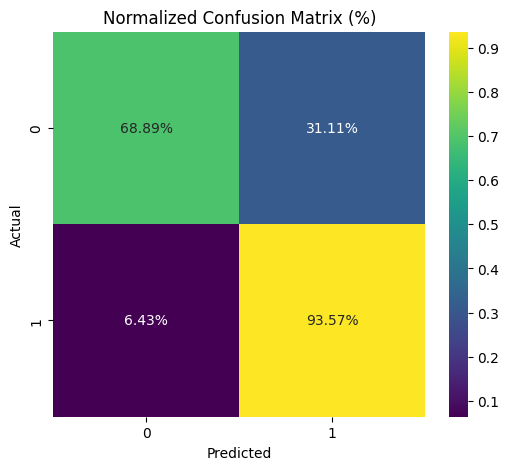

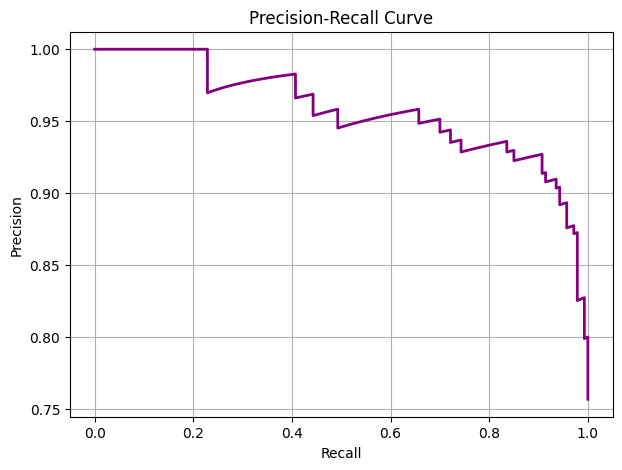

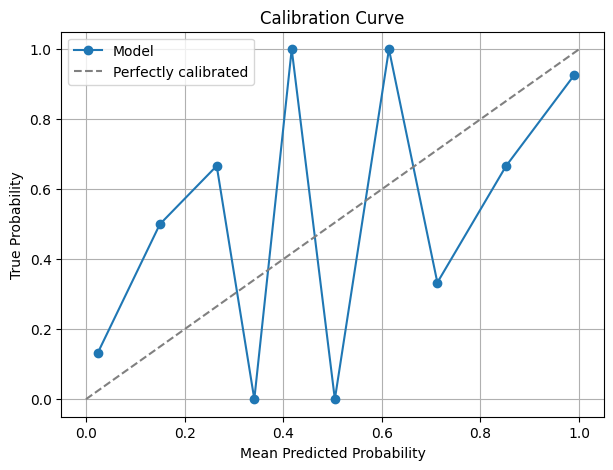

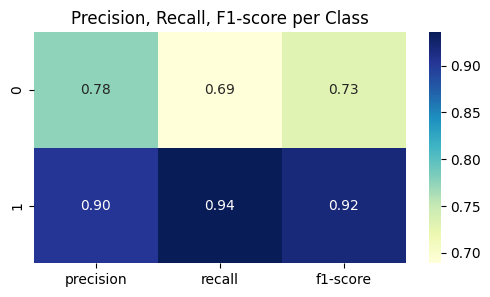

In [ ]:
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.calibration import calibration_curve

# --- Normalized Confusion Matrix ---
conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat_norm, annot=True, fmt=".2%", cmap="viridis", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix (%)')
plt.show()

# --- Precision-Recall Curve ---
prec, rec, _ = precision_recall_curve(y_true, probs)

plt.figure(figsize=(7, 5))
plt.plot(rec, prec, lw=2, color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

# --- Calibration Curve ---
prob_true, prob_pred = calibration_curve(y_true, probs, n_bins=10)

plt.figure(figsize=(7, 5))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()

# --- Classification Report Heatmap ---
report = classification_report(y_true, preds, output_dict=True)
report_df = pd.DataFrame(report).transpose().iloc[:2, :3]  # Only classes 0, 1

plt.figure(figsize=(6, 3))
sns.heatmap(report_df, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Precision, Recall, F1-score per Class")
plt.show()


#ViT-V14_336px Implementation

In [ ]:
import pandas as pd
import numpy as np
import re
import ast

# --- Helper function ---
def clean_embedding_string(embedding_str):
    # Fix spacing issues: insert comma between floats if missing
    fixed_str = re.sub(r'(?<=\d)\s+(?=[+-]?\d)', ', ', embedding_str)

    try:
        return np.array(ast.literal_eval(fixed_str))
    except Exception as e:
        print(f"Error parsing:\n{embedding_str[:80]}...\n{e}")
        return None

# --- File paths ---
train_path = '/content/train_with_embeddings_ViT-L14_336px.csv'
valid_path = '/content/valid_with_embeddings_ViT-L14_336px.csv'
test_path  = '/content/test_with_embeddings_ViT-L14_336px.csv'

# --- Processing function ---
def load_and_process(file_path):
    df = pd.read_csv(file_path)

    # Apply the cleaning function to text and image embeddings
    df['text_embedding_fixed'] = df['text_embedding'].apply(clean_embedding_string)
    df['image_embedding_fixed'] = df['image_embedding'].apply(clean_embedding_string)

    # Drop rows where embeddings are invalid (None)
    df = df.dropna(subset=['text_embedding_fixed', 'image_embedding_fixed'])

    # Ensure that we actually have data to process
    if df.empty:
        print(f"Warning: No valid data found in {file_path}")
        return None, None, None

    # Stack the text and image embeddings into numpy arrays
    X_text = np.stack(df['text_embedding_fixed'].values)
    X_image = np.stack(df['image_embedding_fixed'].values)
    y = df['label'].values

    return X_text, X_image, y

# --- Apply to all splits ---
X_text_train, X_image_train, y_train = load_and_process(train_path)
X_text_val,   X_image_val,   y_val   = load_and_process(valid_path)
X_text_test,  X_image_test,  y_test  = load_and_process(test_path)

# Check for any None values in the results
if X_text_train is None:
    print("Error: No valid data in train set.")
if X_text_val is None:
    print("Error: No valid data in validation set.")
if X_text_test is None:
    print("Error: No valid data in test set.")


In [ ]:
# Display the first few rows of each split to verify the data format
print("Train Data:")
print(pd.DataFrame({'text_embedding': X_text_train.tolist(), 'image_embedding': X_image_train.tolist(), 'label': y_train}).head())

print("\nValidation Data:")
print(pd.DataFrame({'text_embedding': X_text_val.tolist(), 'image_embedding': X_image_val.tolist(), 'label': y_val}).head())

print("\nTest Data:")
print(pd.DataFrame({'text_embedding': X_text_test.tolist(), 'image_embedding': X_image_test.tolist(), 'label': y_test}).head())


Train Data:
                                      text_embedding  \
0  [[-0.013618, 0.0040131, 0.0010052, 0.015976, 0...   
1  [[0.045166, -0.024109, 0.023224, -0.019089, -0...   
2  [[0.04776, 0.011139, 0.038513, -0.01123, -0.03...   
3  [[0.016083, -0.00056839, 0.0019836, -0.0059814...   
4  [[-0.012299, -0.0052834, -0.050812, 0.0043182,...   

                                     image_embedding  label  
0  [[-0.0074005, -0.052429, -0.0087967, 0.028915,...      1  
1  [[0.02005, 0.029114, 0.044464, -0.014633, -0.0...      1  
2  [[0.0036068, 0.0047684, 0.017502, 0.0055084, -...      0  
3  [[-0.022537, 0.031769, -0.011414, 0.062103, -0...      1  
4  [[0.035278, -0.080566, -0.077332, 0.018158, 0....      1  

Validation Data:
                                      text_embedding  \
0  [[-0.0014048, -0.0072861, -0.0032234, 7.8201e-...   
1  [[0.010338, -0.0056496, 0.0052757, 0.030136, 0...   
2  [[0.0289, -0.018127, -0.0091705, 0.015602, -0....   
3  [[0.0070152, 0.00041842, 0.014702,

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import optuna
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import numpy as np

# Flatten if 3D
def flatten_if_3d(X):
    if X.ndim == 3:
        return X.reshape((X.shape[0], -1))
    return X

X_text_train_flat = flatten_if_3d(X_text_train)
X_image_train_flat = flatten_if_3d(X_image_train)
X_text_val_flat = flatten_if_3d(X_text_val)
X_image_val_flat = flatten_if_3d(X_image_val)


# ---- Combine and Normalize ----
X_train = np.concatenate([X_text_train_flat, X_image_train_flat], axis=1)
X_val   = np.concatenate([X_text_val_flat, X_image_val_flat], axis=1)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

# ---- Convert to Tensors ----
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor   = torch.tensor(X_val_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor   = torch.tensor(y_val, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)

# ---- Loss Function ----
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

# ---- Model Definition ----
class DynamicMLP(nn.Module):
    def __init__(self, input_dim, hidden_layers, activation, dropout_rate):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(activation())
            layers.append(nn.Dropout(dropout_rate))
            prev = h
        layers.append(nn.Linear(prev, 2))  # Assuming binary classification
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# ---- Objective Function for Optuna ----
def objective(trial):
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "AdamW", "SGD"])
    lr = trial.suggest_categorical("lr", [1e-2, 1e-3, 5e-4])
    weight_decay = trial.suggest_categorical("weight_decay", [1e-3, 1e-4, 0])
    dropout = trial.suggest_categorical("dropout", [0.2, 0.3, 0.4])
    activation_name = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU", "GELU"])
    loss_fn_name = trial.suggest_categorical("loss_fn", ["FocalLoss", "CrossEntropy"])
    layer_choice = trial.suggest_categorical("layer_config", [
        [256, 128],
        [512, 256, 128],
        [512, 256, 128, 64]
    ])

    activation = {"ReLU": nn.ReLU, "LeakyReLU": nn.LeakyReLU, "GELU": nn.GELU}[activation_name]
    input_dim = X_train_tensor.shape[1]
    model = DynamicMLP(input_dim, layer_choice, activation, dropout)

    if optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    else:
        optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr, weight_decay=weight_decay)

    if loss_fn_name == "FocalLoss":
        criterion = FocalLoss()
    else:
        class_counts = np.bincount(y_train)
        weights = torch.tensor(1. / class_counts, dtype=torch.float32)
        criterion = nn.CrossEntropyLoss(weight=weights)

    # Train
    model.train()
    for epoch in range(15):
        for xb, yb in train_loader:
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()

    # Validate
    model.eval()
    with torch.no_grad():
        preds = model(X_val_tensor)
        acc = accuracy_score(y_val, preds.argmax(dim=1).numpy())
    return acc

# ---- Run Optuna ----
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, timeout=1800)

# ---- Best Trial Info ----
print("Best Trial:")
trial = study.best_trial
print(f"  Accuracy: {trial.value}")
print("  Best Params:", trial.params)


[I 2025-05-11 14:52:11,889] A new study created in memory with name: no-name-ed22e14c-ec27-49be-985b-725a54d9caef
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 128] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [512, 256, 128] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [512, 256, 128, 64] which is of type list.
  warnings.warn(message)
[I 2025-05-11 14:52:17,710] Trial 0 finished with value: 0.909090909

Best Trial:
  Accuracy: 0.9393939393939394
  Best Params: {'optimizer': 'AdamW', 'lr': 0.01, 'weight_decay': 0, 'dropout': 0.4, 'activation': 'LeakyReLU', 'loss_fn': 'FocalLoss', 'layer_config': [512, 256, 128]}



--- Training: TEXT_ONLY ---
[text_only] Epoch 1 | Val Acc: 0.8384 | Best: 0.8384
[text_only] Epoch 2 | Val Acc: 0.8333 | Best: 0.8384
[text_only] Epoch 3 | Val Acc: 0.8232 | Best: 0.8384
[text_only] Epoch 4 | Val Acc: 0.8333 | Best: 0.8384
[text_only] Epoch 5 | Val Acc: 0.8384 | Best: 0.8384
[text_only] Epoch 6 | Val Acc: 0.7677 | Best: 0.8384
[text_only] Epoch 7 | Val Acc: 0.8030 | Best: 0.8384
[text_only] Epoch 8 | Val Acc: 0.8384 | Best: 0.8384
[text_only] Epoch 9 | Val Acc: 0.8131 | Best: 0.8384
[text_only] Epoch 10 | Val Acc: 0.8232 | Best: 0.8384
[text_only] Epoch 11 | Val Acc: 0.8434 | Best: 0.8434
[text_only] Epoch 12 | Val Acc: 0.7222 | Best: 0.8434
[text_only] Epoch 13 | Val Acc: 0.8081 | Best: 0.8434
[text_only] Epoch 14 | Val Acc: 0.7121 | Best: 0.8434
[text_only] Epoch 15 | Val Acc: 0.8081 | Best: 0.8434
[text_only] Epoch 16 | Val Acc: 0.8687 | Best: 0.8687
[text_only] Epoch 17 | Val Acc: 0.8283 | Best: 0.8687
[text_only] Epoch 18 | Val Acc: 0.8232 | Best: 0.8687
[text_on

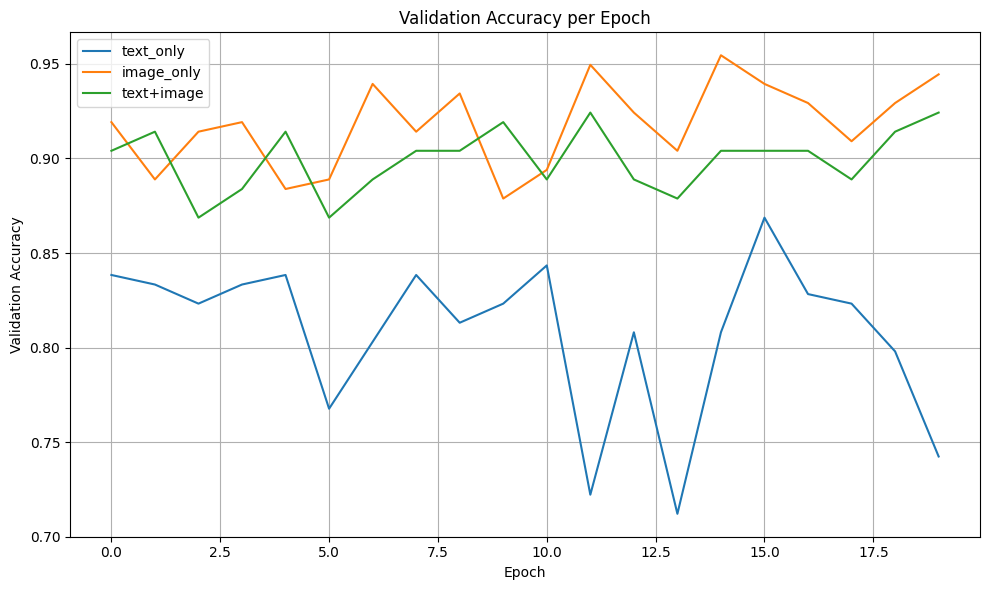

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import os

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Flatten 3D embeddings if needed
def flatten_if_3d(X):
    return X.reshape((X.shape[0], -1)) if X.ndim == 3 else X

X_text_train_flat = flatten_if_3d(X_text_train)
X_image_train_flat = flatten_if_3d(X_image_train)
X_text_val_flat   = flatten_if_3d(X_text_val)
X_image_val_flat  = flatten_if_3d(X_image_val)

# --- Scaler ---
scaler = StandardScaler()

data_configs = {
    'text_only': (X_text_train_flat, X_text_val_flat),
    'image_only': (X_image_train_flat, X_image_val_flat),
    'text+image': (np.concatenate([X_text_train_flat, X_image_train_flat], axis=1),
                   np.concatenate([X_image_val_flat, X_image_val_flat], axis=1))
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Focal Loss ---
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return loss.mean()

# --- MLP Model ---
class MLP(nn.Module):
    def __init__(self, input_dim, layer_config, dropout, activation):
        super(MLP, self).__init__()
        layers = []
        for units in layer_config:
            layers.append(nn.Linear(input_dim, units))
            layers.append(nn.LeakyReLU() if activation == 'LeakyReLU' else nn.ReLU())
            layers.append(nn.Dropout(dropout))
            input_dim = units
        layers.append(nn.Linear(input_dim, 2))  # Binary classification
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# --- Best Params ---
best_params = {
    'optimizer': 'AdamW',
    'lr': 0.01,
    'weight_decay': 0,
    'dropout': 0.4,
    'activation': 'LeakyReLU',
    'loss_fn': FocalLoss(),
    'layer_config': [512, 256, 128]
}

# --- Training Function ---
def train_model(X_train, X_val, y_train, y_val, config_name, save_dir='best_models'):
    os.makedirs(save_dir, exist_ok=True)

    X_train = scaler.fit_transform(X_train)
    X_val   = scaler.transform(X_val)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_val_tensor   = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor   = torch.tensor(y_val, dtype=torch.long)

    train_ds = TensorDataset(X_train_tensor, y_train_tensor)
    val_ds   = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)

    model = MLP(
        input_dim=X_train.shape[1],
        layer_config=best_params['layer_config'],
        dropout=best_params['dropout'],
        activation=best_params['activation']
    ).to(device)

    optimizer = getattr(optim, best_params['optimizer'])(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
    criterion = best_params['loss_fn']

    best_acc = 0
    best_weights = None
    val_accuracies = []

    for epoch in range(20):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

        # --- Validation ---
        model.eval()
        preds = []
        targets = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                logits = model(xb)
                pred = torch.argmax(logits, dim=1).cpu().numpy()
                preds.extend(pred)
                targets.extend(yb.numpy())

        acc = accuracy_score(targets, preds)
        val_accuracies.append(acc)

        if acc > best_acc:
            best_acc = acc
            best_weights = model.state_dict()

        print(f"[{config_name}] Epoch {epoch+1} | Val Acc: {acc:.4f} | Best: {best_acc:.4f}")

    # Save best weights
    torch.save(best_weights, os.path.join(save_dir, f'{config_name}_best.pt'))

    return val_accuracies

# --- Run Training for All Configurations ---
results = {}

for name, (X_train_cfg, X_val_cfg) in data_configs.items():
    print(f"\n--- Training: {name.upper()} ---")
    acc_curve = train_model(X_train_cfg, X_val_cfg, y_train, y_val, name)
    results[name] = acc_curve

# --- Plotting ---
plt.figure(figsize=(10, 6))
for name, accs in results.items():
    plt.plot(accs, label=name)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



--- Training: TEXT_ONLY ---
[text_only] Epoch 1 | Val Acc: 0.8384 | Best: 0.8384
[text_only] Epoch 2 | Val Acc: 0.8333 | Best: 0.8384
[text_only] Epoch 3 | Val Acc: 0.8232 | Best: 0.8384
[text_only] Epoch 4 | Val Acc: 0.8333 | Best: 0.8384
[text_only] Epoch 5 | Val Acc: 0.8384 | Best: 0.8384
[text_only] Epoch 6 | Val Acc: 0.7677 | Best: 0.8384
[text_only] Epoch 7 | Val Acc: 0.8030 | Best: 0.8384
[text_only] Epoch 8 | Val Acc: 0.8384 | Best: 0.8384
[text_only] Epoch 9 | Val Acc: 0.8131 | Best: 0.8384
[text_only] Epoch 10 | Val Acc: 0.8232 | Best: 0.8384
[text_only] Epoch 11 | Val Acc: 0.8434 | Best: 0.8434
[text_only] Epoch 12 | Val Acc: 0.7222 | Best: 0.8434
[text_only] Epoch 13 | Val Acc: 0.8081 | Best: 0.8434
[text_only] Epoch 14 | Val Acc: 0.7121 | Best: 0.8434
[text_only] Epoch 15 | Val Acc: 0.8081 | Best: 0.8434
[text_only] Epoch 16 | Val Acc: 0.8687 | Best: 0.8687
[text_only] Epoch 17 | Val Acc: 0.8283 | Best: 0.8687
[text_only] Epoch 18 | Val Acc: 0.8232 | Best: 0.8687
[text_on

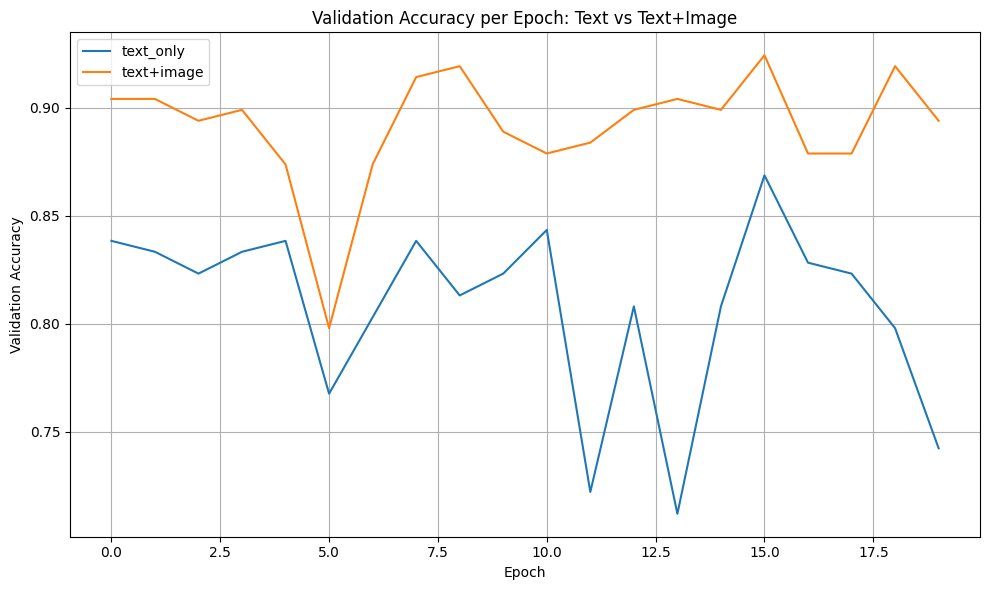

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import os

# --- Seed setup ---
torch.manual_seed(42)
np.random.seed(42)

# --- Flattening helper ---
def flatten_if_3d(X):
    return X.reshape((X.shape[0], -1)) if X.ndim == 3 else X

X_text_train_flat = flatten_if_3d(X_text_train)
X_image_train_flat = flatten_if_3d(X_image_train)
X_text_val_flat   = flatten_if_3d(X_text_val)
X_image_val_flat  = flatten_if_3d(X_image_val)

# --- Scaler ---
scaler = StandardScaler()

# Only comparing text and text+image
data_configs = {
    'text_only': (X_text_train_flat, X_text_val_flat),
    'text+image': (np.concatenate([X_text_train_flat, X_image_train_flat], axis=1),
                   np.concatenate([X_text_val_flat, X_image_val_flat], axis=1))
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Focal Loss ---
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return loss.mean()

# --- MLP Model ---
class MLP(nn.Module):
    def __init__(self, input_dim, layer_config, dropout, activation):
        super(MLP, self).__init__()
        layers = []
        for units in layer_config:
            layers.append(nn.Linear(input_dim, units))
            layers.append(nn.LeakyReLU() if activation == 'LeakyReLU' else nn.ReLU())
            layers.append(nn.Dropout(dropout))
            input_dim = units
        layers.append(nn.Linear(input_dim, 2))  # Binary classification
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# --- Best Params ---
best_params = {
    'optimizer': 'AdamW',
    'lr': 0.01,
    'weight_decay': 0,
    'dropout': 0.4,
    'activation': 'LeakyReLU',
    'loss_fn': FocalLoss(),
    'layer_config': [512, 256, 128]
}

# --- Training Function ---
def train_model(X_train, X_val, y_train, y_val, config_name, save_dir='best_models'):
    os.makedirs(save_dir, exist_ok=True)

    X_train = scaler.fit_transform(X_train)
    X_val   = scaler.transform(X_val)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_val_tensor   = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor   = torch.tensor(y_val, dtype=torch.long)

    train_ds = TensorDataset(X_train_tensor, y_train_tensor)
    val_ds   = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)

    model = MLP(
        input_dim=X_train.shape[1],
        layer_config=best_params['layer_config'],
        dropout=best_params['dropout'],
        activation=best_params['activation']
    ).to(device)

    optimizer = getattr(optim, best_params['optimizer'])(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
    criterion = best_params['loss_fn']

    best_acc = 0
    best_weights = None
    val_accuracies = []

    for epoch in range(20):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

        # --- Validation ---
        model.eval()
        preds = []
        targets = []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                logits = model(xb)
                pred = torch.argmax(logits, dim=1).cpu().numpy()
                preds.extend(pred)
                targets.extend(yb.numpy())

        acc = accuracy_score(targets, preds)
        val_accuracies.append(acc)

        if acc > best_acc:
            best_acc = acc
            best_weights = model.state_dict()

        print(f"[{config_name}] Epoch {epoch+1} | Val Acc: {acc:.4f} | Best: {best_acc:.4f}")

    # Save best weights
    torch.save(best_weights, os.path.join(save_dir, f'{config_name}_best.pt'))

    return val_accuracies

# --- Run Training for Both Configurations ---
results = {}

for name, (X_train_cfg, X_val_cfg) in data_configs.items():
    print(f"\n--- Training: {name.upper()} ---")
    acc_curve = train_model(X_train_cfg, X_val_cfg, y_train, y_val, name)
    results[name] = acc_curve

# --- Plotting ---
plt.figure(figsize=(10, 6))
for name, accs in results.items():
    plt.plot(accs, label=name)
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy per Epoch: Text vs Text+Image')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 1: Train Loss: 0.1824, Acc: 0.8387 | Val Loss: 0.1433, Acc: 0.8889 | Best Acc: 0.8889
Epoch 2: Train Loss: 0.1472, Acc: 0.9080 | Val Loss: 0.1022, Acc: 0.8889 | Best Acc: 0.8889
Epoch 3: Train Loss: 0.1530, Acc: 0.8950 | Val Loss: 0.0746, Acc: 0.8889 | Best Acc: 0.8889
Epoch 4: Train Loss: 0.2998, Acc: 0.8983 | Val Loss: 0.2818, Acc: 0.9040 | Best Acc: 0.9040
Epoch 5: Train Loss: 0.4155, Acc: 0.9123 | Val Loss: 1.0172, Acc: 0.8586 | Best Acc: 0.9040
Epoch 6: Train Loss: 1.0941, Acc: 0.8885 | Val Loss: 0.4336, Acc: 0.8889 | Best Acc: 0.9040
Epoch 7: Train Loss: 2.7703, Acc: 0.9177 | Val Loss: 2.4274, Acc: 0.9091 | Best Acc: 0.9091
Epoch 8: Train Loss: 4.7392, Acc: 0.9275 | Val Loss: 2.8756, Acc: 0.9293 | Best Acc: 0.9293
Epoch 9: Train Loss: 2.8621, Acc: 0.9297 | Val Loss: 1.8882, Acc: 0.8737 | Best Acc: 0.9293
Epoch 10: Train Loss: 1.6327, Acc: 0.9491 | Val Loss: 16.6793, Acc: 0.9040 | Best Acc: 0.9293
Epoch 11: Train Loss: 3.0830, Acc: 0.9675 | Val Loss: 10.5478, Acc: 0.8737 | B

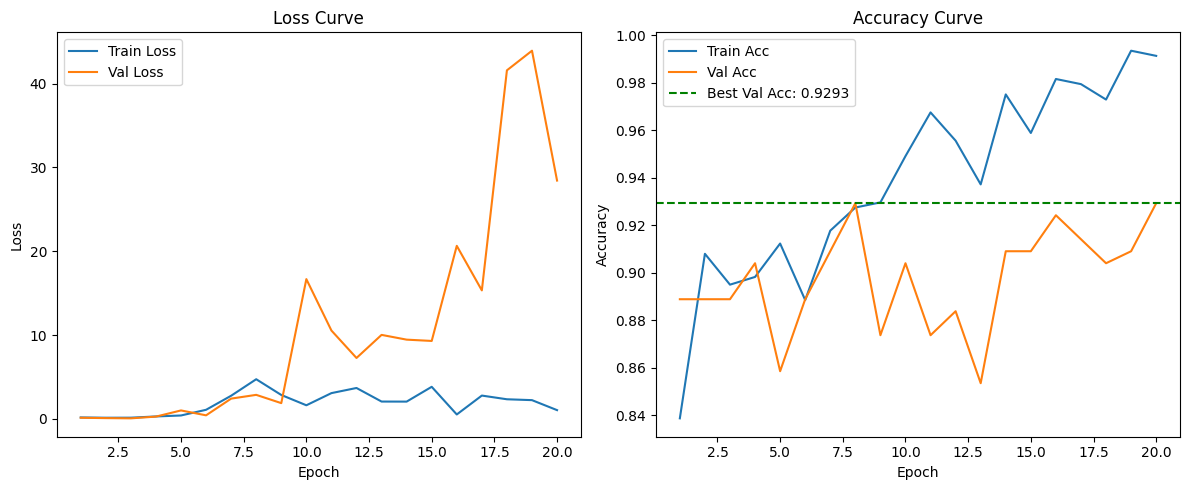

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return loss.mean()

# MLP Model
class MLP(nn.Module):
    def __init__(self, input_dim, layer_config, dropout, activation):
        super(MLP, self).__init__()
        layers = []
        for units in layer_config:
            layers.append(nn.Linear(input_dim, units))
            layers.append(nn.LeakyReLU() if activation == 'LeakyReLU' else nn.ReLU())
            layers.append(nn.Dropout(dropout))
            input_dim = units
        layers.append(nn.Linear(input_dim, 2))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Flatten helper
def flatten_if_3d(X):
    return X.reshape((X.shape[0], -1)) if X.ndim == 3 else X

# Combine and scale features
X_train_combined = np.concatenate([
    flatten_if_3d(X_text_train),
    flatten_if_3d(X_image_train)
], axis=1)
X_val_combined = np.concatenate([
    flatten_if_3d(X_text_val),
    flatten_if_3d(X_image_val)
], axis=1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_val_scaled = scaler.transform(X_val_combined)

# Tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64)

# Hyperparameters
params = {
    'optimizer': 'AdamW',
    'lr': 0.01,
    'weight_decay': 0,
    'dropout': 0.4,
    'activation': 'LeakyReLU',
    'loss_fn': 'FocalLoss',
    'layer_config': [512, 256, 128]
}

# Model and optimizer
model = MLP(X_train_scaled.shape[1], params['layer_config'], params['dropout'], params['activation']).to(device)
optimizer = getattr(torch.optim, params['optimizer'])(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
criterion = FocalLoss() if params['loss_fn'] == 'FocalLoss' else nn.CrossEntropyLoss()

# Tracking variables
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_acc, best_model_wts = 0, None

# Training loop
for epoch in range(20):
    model.train()
    total_loss, correct = 0, 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
        correct += (out.argmax(dim=1) == yb).sum().item()
    train_loss = total_loss / len(train_loader.dataset)
    train_acc = correct / len(train_loader.dataset)

    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            out = model(xb)
            loss = criterion(out, yb)
            total_loss += loss.item() * xb.size(0)
            correct += (out.argmax(dim=1) == yb).sum().item()
    val_loss = total_loss / len(val_loader.dataset)
    val_acc = correct / len(val_loader.dataset)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = model.state_dict()

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f} | Best Acc: {best_acc:.4f}")

# Save best model
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), "best_model_text_image.pt")

# Plot training metrics
epochs = range(1, len(train_losses)+1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.axhline(best_acc, color='green', linestyle='--', label=f'Best Val Acc: {best_acc:.4f}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Ensure X_text_train and X_image_train are flattened and concatenated properly
X_train_combined = np.concatenate([
    flatten_if_3d(X_text_train),  # Flatten X_text_train if it's 3D
    flatten_if_3d(X_image_train)  # Flatten X_image_train if it's 3D
], axis=1)

X_val_combined = np.concatenate([
    flatten_if_3d(X_text_val),    # Flatten X_text_val if it's 3D
    flatten_if_3d(X_image_val)    # Flatten X_image_val if it's 3D
], axis=1)

# Ensure the dimensions are correct
print("X_train_combined shape:", X_train_combined.shape)
print("X_val_combined shape:", X_val_combined.shape)


X_train_combined shape: (924, 1536)
X_val_combined shape: (198, 1536)


In [ ]:
# Flatten helper
def flatten_if_3d(X):
    return X.reshape((X.shape[0], -1)) if X.ndim == 3 else X


In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
import numpy as np

# Step 1: MLP Predictions
model = MLP(1536, params['layer_config'], params['dropout'], params['activation']).to(device)

# Ensure tensors are on the correct device
X_train_tensor = X_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)

model.eval()
with torch.no_grad():
    # Get predicted class labels using argmax
    X_val_tensor = torch.tensor(X_val_combined, dtype=torch.float32).to(device)
    val_logits = model(X_val_tensor)
           # shape: (num_samples, num_classes)
    val_preds_mlp = torch.argmax(val_logits, dim=1).cpu().numpy()  # class predictions


In [ ]:
import xgboost as xgb

model = MLP(1536, params['layer_config'], params['dropout'], params['activation']).to(device)


# Convert combined arrays into tensors and move to the same device as the model
X_train_tensor = torch.tensor(X_train_combined, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val_combined, dtype=torch.float32).to(device)

# Extract predictions from MLP
model.eval()
with torch.no_grad():
    train_preds = model(X_train_tensor).cpu().numpy()
    val_preds = model(X_val_tensor).cpu().numpy()

# Step 2: Train an XGBoost model
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dval = xgb.DMatrix(X_val_scaled, label=y_val)

param = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'multi:softmax',
    'num_class': 2,
    'eval_metric': 'mlogloss'
}

bst = xgb.train(param, dtrain, num_boost_round=100)

# Step 3: Get the final predictions from XGBoost
xgb_preds = bst.predict(dval)

# Step 1: Get class labels from MLP for validation set
val_preds_mlp = np.argmax(val_preds, axis=1)  # Shape: (198,)

# Step 2: XGBoost predictions are already class labels: xgb_preds -> shape (198,)

# Step 3: Ensemble by majority vote (simple case: if both agree, use that; if not, choose MLP)
final_preds = np.where(val_preds_mlp == xgb_preds, val_preds_mlp, xgb_preds)  # or use a different strategy

# Step 4: Compute accuracy
final_acc = accuracy_score(y_val, final_preds)
print(f"Ensemble Accuracy: {final_acc}")


Ensemble Accuracy: 0.8232323232323232


📊 Evaluation Report:
Accuracy : 0.9293
Precision: 0.9691
Recall   : 0.9458
F1 Score : 0.9573

Detailed Classification Report:

              precision    recall  f1-score   support

           0     0.7500    0.8438    0.7941        32
           1     0.9691    0.9458    0.9573       166

    accuracy                         0.9293       198
   macro avg     0.8596    0.8948    0.8757       198
weighted avg     0.9337    0.9293    0.9309       198



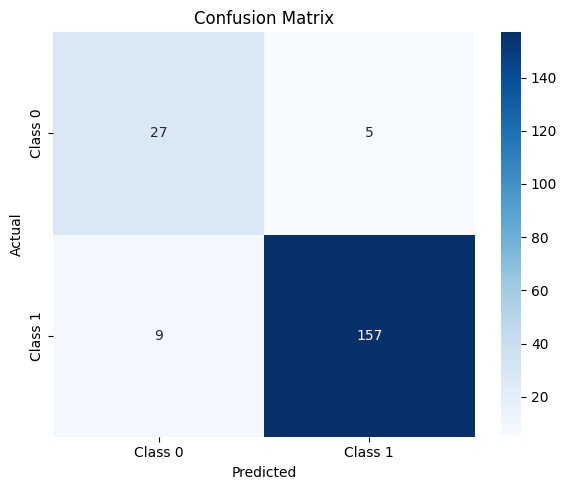

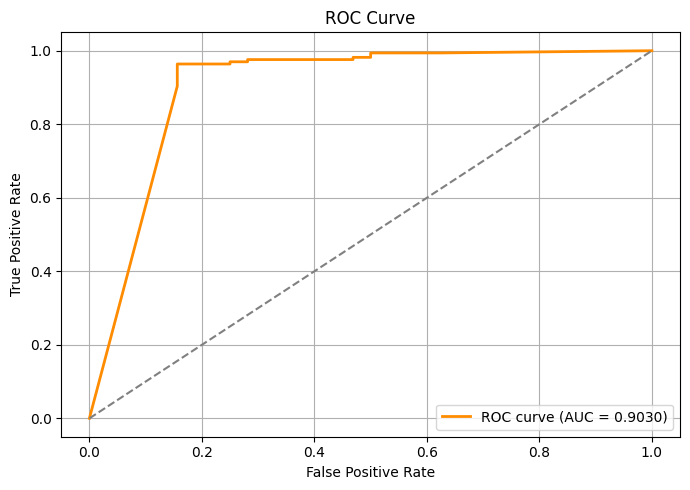

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Reload best model (if not already loaded)
model.load_state_dict(torch.load("best_model_text_image.pt"))
model.eval()

# Get predictions
all_preds, all_probs, all_labels = [], [], []
with torch.no_grad():
    for xb, yb in val_loader:
        out = model(xb)
        probs = F.softmax(out, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of class 1
        all_labels.extend(yb.cpu().numpy())

# Convert to numpy arrays
y_true = np.array(all_labels)
y_pred = np.array(all_preds)
y_score = np.array(all_probs)

# --- Classification Metrics ---
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="binary")
recall = recall_score(y_true, y_pred, average="binary")
f1 = f1_score(y_true, y_pred, average="binary")

print("📊 Evaluation Report:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print("\nDetailed Classification Report:\n")
print(classification_report(y_true, y_pred, digits=4))

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- ROC Curve and AUC ---
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


#Training for RN20x64 model


In [ ]:
import pandas as pd
import numpy as np
import re
import ast

# --- Helper function ---
def clean_embedding_string(embedding_str):
    # Step 1: Fix spacing issues - insert commas between numbers where necessary
    fixed_str = re.sub(r'(?<=\d)\s+(?=[+-]?\d)', ', ', embedding_str)  # Match space between digits

    # Step 2: Remove extraneous characters (e.g., '...')
    fixed_str = re.sub(r'\.\.\.', '', fixed_str)  # Remove '...'

    # Step 3: Ensure commas between numbers, handle any missing ones
    fixed_str = re.sub(r'(?<=\d)\s+(?=\-?\d)', ', ', fixed_str)  # Ensure comma after number if missing

    # Step 4: Handle leading or trailing spaces
    fixed_str = fixed_str.strip()

    # Debugging: Print the fixed string before trying to parse
    print(f"Fixed String (before parsing): {fixed_str[:100]}...")  # Show only the first 100 chars for debugging

    try:
        # Step 5: Parse the fixed string into a numpy array
        return np.array(ast.literal_eval(fixed_str))
    except Exception as e:
        # Print a more detailed error if it fails
        print(f"Error parsing the string:\n{embedding_str[:100]}...\nFixed string:\n{fixed_str[:100]}...\n{e}")
        return None

# --- File paths ---
train_path = '/content/train_with_embeddings_RN50x64.csv'
valid_path = '/content/valid_with_embeddings_RN50x64.csv'
test_path  = '/content/test_with_embeddings_RN50x64.csv'

# --- Processing function ---
def load_and_process(file_path):
    df = pd.read_csv(file_path)

    # Apply the cleaning function to text and image embeddings
    df['text_embedding_fixed'] = df['text_embedding'].apply(clean_embedding_string)
    df['image_embedding_fixed'] = df['image_embedding'].apply(clean_embedding_string)

    # Drop rows where embeddings are invalid (None)
    df = df.dropna(subset=['text_embedding_fixed', 'image_embedding_fixed'])

    # Ensure that we actually have data to process
    if df.empty:
        print(f"Warning: No valid data found in {file_path}")
        return None, None, None

    # Stack the text and image embeddings into numpy arrays
    X_text = np.stack(df['text_embedding_fixed'].values)
    X_image = np.stack(df['image_embedding_fixed'].values)
    y = df['label'].values

    return X_text, X_image, y

# --- Apply to all splits ---
X_text_train, X_image_train, y_train = load_and_process(train_path)
X_text_val, X_image_val, y_val = load_and_process(valid_path)
X_text_test, X_image_test, y_test = load_and_process(test_path)

# Check for any None values in the results
if X_text_train is None:
    print("Error: No valid data in train set.")
if X_text_val is None:
    print("Error: No valid data in validation set.")
if X_text_test is None:
    print("Error: No valid data in test set.")


Fixed String (before parsing): [[ 0.00955, 0.01671, 0.009155, 0.002924, 0.0062, -0.01504 ]]...
Fixed String (before parsing): [[-0.02303, 0.013954, 0.00961, 0.01646, 0.001059, 0.0009613]]...
Fixed String (before parsing): [[-0.01767, -0.02869, 0.0134, 0.00701, 0.0269, -0.01154]]...
Fixed String (before parsing): [[-0.02808, -0.01285, 0.01614, 0.014175, -0.01683, 0.01373 ]]...
Fixed String (before parsing): [[-0.02293, 0.02408, 0.01336, -0.01874, -0.00895, 0.02318]]...
Fixed String (before parsing): [[-0.002968, -0.0001626, 0.0002782, -0.000532, -0.01872, -0.010994 ]]...
Fixed String (before parsing): [[ 0.01947, -0.006374, -0.001963, -0.01004, 0.002508, -0.03625 ]]...
Fixed String (before parsing): [[-0.02592, -0.01034, -0.002428, -0.00612, -0.04526, -0.02441 ]]...
Fixed String (before parsing): [[-0.003906, 0.02155, 0.01884, 0.00936, -0.00613, -0.01738 ]]...
Fixed String (before parsing): [[-0.01027, 0.03772, 0.0236, -0.01704, -0.00713, -0.002785]]...
Fixed String (before parsing): [[

In [ ]:
# Display the first few rows of each split to verify the data format
print("Train Data:")
print(pd.DataFrame({'text_embedding': X_text_train.tolist(), 'image_embedding': X_image_train.tolist(), 'label': y_train}).head())

print("\nValidation Data:")
print(pd.DataFrame({'text_embedding': X_text_val.tolist(), 'image_embedding': X_image_val.tolist(), 'label': y_val}).head())

print("\nTest Data:")
print(pd.DataFrame({'text_embedding': X_text_test.tolist(), 'image_embedding': X_image_test.tolist(), 'label': y_test}).head())


Train Data:
                                      text_embedding  \
0  [[0.00955, 0.01671, 0.009155, 0.002924, 0.0062...   
1  [[-0.02303, 0.013954, 0.00961, 0.01646, 0.0010...   
2  [[-0.01767, -0.02869, 0.0134, 0.00701, 0.0269,...   
3  [[-0.02808, -0.01285, 0.01614, 0.014175, -0.01...   
4  [[-0.02293, 0.02408, 0.01336, -0.01874, -0.008...   

                                     image_embedding  label  
0  [[0.03687, -0.04318, -0.02332, -0.00201, 0.025...      1  
1  [[-0.00452, -0.01682, 0.02597, 0.01379, 0.0124...      1  
2  [[-0.0242, -0.02925, 0.03143, 0.008675, 0.0015...      0  
3  [[-0.04294, -0.00724, 0.0327, -0.04855, -0.030...      1  
4  [[-0.01171, -0.01482, 0.0367, 0.01698, -0.0065...      1  

Validation Data:
                                      text_embedding  \
0  [[-0.01814, 0.004776, 0.01851, 0.00616, -0.008...   
1  [[0.01249, 0.01692, -0.006668, 0.01578, 0.0250...   
2  [[-0.005905, 0.02664, 0.00428, -0.02652, 0.004...   
3  [[-0.00625, 0.006615, 0.00342, 0.0

In [ ]:
print(X_text_train)  # This should not be None
print(X_image_train)  # This should not be None


[[[ 0.00955    0.01671    0.009155   0.002924   0.0062    -0.01504  ]]

 [[-0.02303    0.013954   0.00961    0.01646    0.001059   0.0009613]]

 [[-0.01767   -0.02869    0.0134     0.00701    0.0269    -0.01154  ]]

 ...

 [[ 0.0174     0.0223     0.02124   -0.00677    0.03073   -0.0108   ]]

 [[-0.029      0.04953    0.008804   0.0004735 -0.018      0.01375  ]]

 [[ 0.001312   0.000514   0.01523    0.01576   -0.00548   -0.00587  ]]]
[[[ 0.03687    -0.04318    -0.02332    -0.00201     0.0255
    0.007004  ]]

 [[-0.00452    -0.01682     0.02597     0.01379     0.0124
   -0.00813   ]]

 [[-0.0242     -0.02925     0.03143     0.008675    0.001599
    0.0266    ]]

 ...

 [[ 0.01784    -0.0023     -0.01025    -0.003546   -0.03778
    0.00569   ]]

 [[-0.01573     0.0313      0.04993     0.0151     -0.00010926
    0.04755   ]]

 [[-0.002787   -0.03098     0.0316      0.02081     0.004208
    0.0346    ]]]


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import optuna
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import numpy as np

# Flatten if 3D
def flatten_if_3d(X):
    if X.ndim == 3:
        return X.reshape((X.shape[0], -1))
    return X

X_text_train_flat = flatten_if_3d(X_text_train)
X_image_train_flat = flatten_if_3d(X_image_train)
X_text_val_flat = flatten_if_3d(X_text_val)
X_image_val_flat = flatten_if_3d(X_image_val)


# ---- Combine and Normalize ----
X_train = np.concatenate([X_text_train_flat, X_image_train_flat], axis=1)
X_val   = np.concatenate([X_text_val_flat, X_image_val_flat], axis=1)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

# ---- Convert to Tensors ----
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor   = torch.tensor(X_val_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor   = torch.tensor(y_val, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)

# ---- Loss Function ----
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

# ---- Model Definition ----
class DynamicMLP(nn.Module):
    def __init__(self, input_dim, hidden_layers, activation, dropout_rate):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_layers:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(activation())
            layers.append(nn.Dropout(dropout_rate))
            prev = h
        layers.append(nn.Linear(prev, 2))  # Assuming binary classification
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# ---- Objective Function for Optuna ----
def objective(trial):
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "AdamW", "SGD"])
    lr = trial.suggest_categorical("lr", [1e-2, 1e-3, 5e-4])
    weight_decay = trial.suggest_categorical("weight_decay", [1e-3, 1e-4, 0])
    dropout = trial.suggest_categorical("dropout", [0.2, 0.3, 0.4])
    activation_name = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU", "GELU"])
    loss_fn_name = trial.suggest_categorical("loss_fn", ["FocalLoss", "CrossEntropy"])
    layer_choice = trial.suggest_categorical("layer_config", [
        [256, 128],
        [512, 256, 128],
        [512, 256, 128, 64]
    ])

    activation = {"ReLU": nn.ReLU, "LeakyReLU": nn.LeakyReLU, "GELU": nn.GELU}[activation_name]
    input_dim = X_train_tensor.shape[1]
    model = DynamicMLP(input_dim, layer_choice, activation, dropout)

    if optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    else:
        optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr, weight_decay=weight_decay)

    if loss_fn_name == "FocalLoss":
        criterion = FocalLoss()
    else:
        class_counts = np.bincount(y_train)
        weights = torch.tensor(1. / class_counts, dtype=torch.float32)
        criterion = nn.CrossEntropyLoss(weight=weights)

    # Train
    model.train()
    for epoch in range(15):
        for xb, yb in train_loader:
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()

    # Validate
    model.eval()
    with torch.no_grad():
        preds = model(X_val_tensor)
        acc = accuracy_score(y_val, preds.argmax(dim=1).numpy())
    return acc

# ---- Run Optuna ----
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, timeout=1800)

# ---- Best Trial Info ----
print("Best Trial:")
trial = study.best_trial
print(f"  Accuracy: {trial.value}")
print("  Best Params:", trial.params)


[I 2025-05-11 15:18:53,954] A new study created in memory with name: no-name-0016739e-bade-456b-81b7-f05345dbf461
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 128] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [512, 256, 128] which is of type list.
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [512, 256, 128, 64] which is of type list.
  warnings.warn(message)
[I 2025-05-11 15:18:55,691] Trial 0 finished with value: 0.651515151

Best Trial:
  Accuracy: 0.8484848484848485
  Best Params: {'optimizer': 'Adam', 'lr': 0.01, 'weight_decay': 0.0001, 'dropout': 0.2, 'activation': 'ReLU', 'loss_fn': 'FocalLoss', 'layer_config': [512, 256, 128, 64]}
